In [1]:
import json
import time
import numpy as np

In [2]:
from itertools import combinations
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = []

with open('../data/reddit/dataset.json', 'r') as dataset_json:
    dataset = json.loads(dataset_json.read())

#### Filter out deleted

In [5]:
filtered_dataset = list(filter(lambda item: item['author'] != 'deleted', dataset))

print(f'{len(filtered_dataset)} / {len(dataset)}')

32805 / 36873


#### Get month and year from epoch

In [6]:
for record in filtered_dataset:
    
    created_at = time.localtime(record['created_at'])
    
    record['year'] = created_at.tm_year
    record['month'] = created_at.tm_mon

#### Group by year by month by post

In [7]:
breakouts = {}

for record in filtered_dataset:
    a_key = record['year']
    if a_key not in breakouts:
        breakouts[a_key] = {}
        
    b_key = record['month']
    if b_key not in breakouts[a_key]:
        breakouts[a_key][b_key] = defaultdict(list)
        
    by_month = breakouts[a_key][b_key]
        
    c_key = record['post_id']
    breakouts[a_key][b_key][c_key].append(record)

#### Remove all posts with only one author attached

In [8]:
removed_count = 0

a_keys = list(breakouts.keys())
for a_key in a_keys:
    
    b_keys = list(breakouts[a_key].keys())
    for b_key in b_keys:
        
        c_keys = list(breakouts[a_key][b_key].keys())
        for c_key in c_keys:
            
            authors = list(
                map(
                    lambda interaction: interaction['author'],
                    breakouts[a_key][b_key][c_key]
                )
            )
            
            if len(np.unique(authors)) == 1:
                removed_count += 1
                del breakouts[a_key][b_key][c_key]
                
print(f'deleted# {removed_count}')

deleted# 2741


In [9]:
## save off groupings,
with open('../data/reddit/siacoin_grouping.json', 'w') as siacoin_grouping_json:
    siacoin_grouping_json.write(json.dumps(breakouts))

#### Create edgelists by year by month by post

In [10]:
edgelist_breakouts = {}

for year_key in breakouts.keys():
    
    for month_key in breakouts[year_key].keys():
        
        edgelist = []
        for post_key in breakouts[year_key][month_key].keys():
            
            posts = breakouts[year_key][month_key][post_key]
            authors = list(
                map(
                    lambda interaction: interaction['author'], 
                    posts
                )
            )
            
            for a, b in combinations(np.unique(authors), 2):
                sort = sorted([a, b], key = lambda a: a.lower())
                edgelist.append(
                    (sort[0], sort[1])
                )
                
        edgelist_breakouts[f'{year_key}-{month_key}'] = edgelist

In [11]:
## save off groupings,
with open('../data/reddit/siacoin_grouping_edgelists.json', 'w') as siacoin_grouping_edgelists:
    siacoin_grouping_edgelists.write(json.dumps(edgelist_breakouts))

In [12]:
## pull our scrapped historical prices

prices = {}

with open('../data/reddit/siacoin_price.json', 'r') as price_json:
    prices = json.loads(price_json.read())

In [13]:
prices

{'2016-1': 3.540329998941161e-05,
 '2016-2': 0.00014594300591852516,
 '2016-3': 0.00017359199409838766,
 '2016-4': 0.00014734899741597474,
 '2016-5': 0.00035821201163344085,
 '2016-6': 0.0011316200252622366,
 '2016-7': 0.0008670879760757089,
 '2016-8': 0.0006357270176522434,
 '2016-9': 0.0007552350289188325,
 '2016-10': 0.0004909790004603565,
 '2016-11': 0.00038899300852790475,
 '2016-12': 0.000268881005467847,
 '2017-1': 0.00041142699774354696,
 '2017-2': 0.00042406300781294703,
 '2017-3': 0.000786992022767663,
 '2017-4': 0.001294099958613515,
 '2017-5': 0.012221000157296658,
 '2017-6': 0.022363899275660515,
 '2017-7': 0.014814499765634537,
 '2017-8': 0.010056599974632263,
 '2017-9': 0.009494190104305744,
 '2017-10': 0.005499720107764006,
 '2017-11': 0.006964200176298618,
 '2017-12': 0.038732901215553284,
 '2018-1': 0.11170800030231476,
 '2018-2': 0.03489600121974945,
 '2018-3': 0.023155199363827705,
 '2018-4': 0.03268929943442345,
 '2018-5': 0.0291811004281044,
 '2018-6': 0.018454499

In [14]:
def sorter(key):
    parts = key.split('-')
    
    year = parts[0]
    month = parts[1]
    
    if len(month) == 1:
        month = f'0{month}'
        
    return f'{year}-{month}'

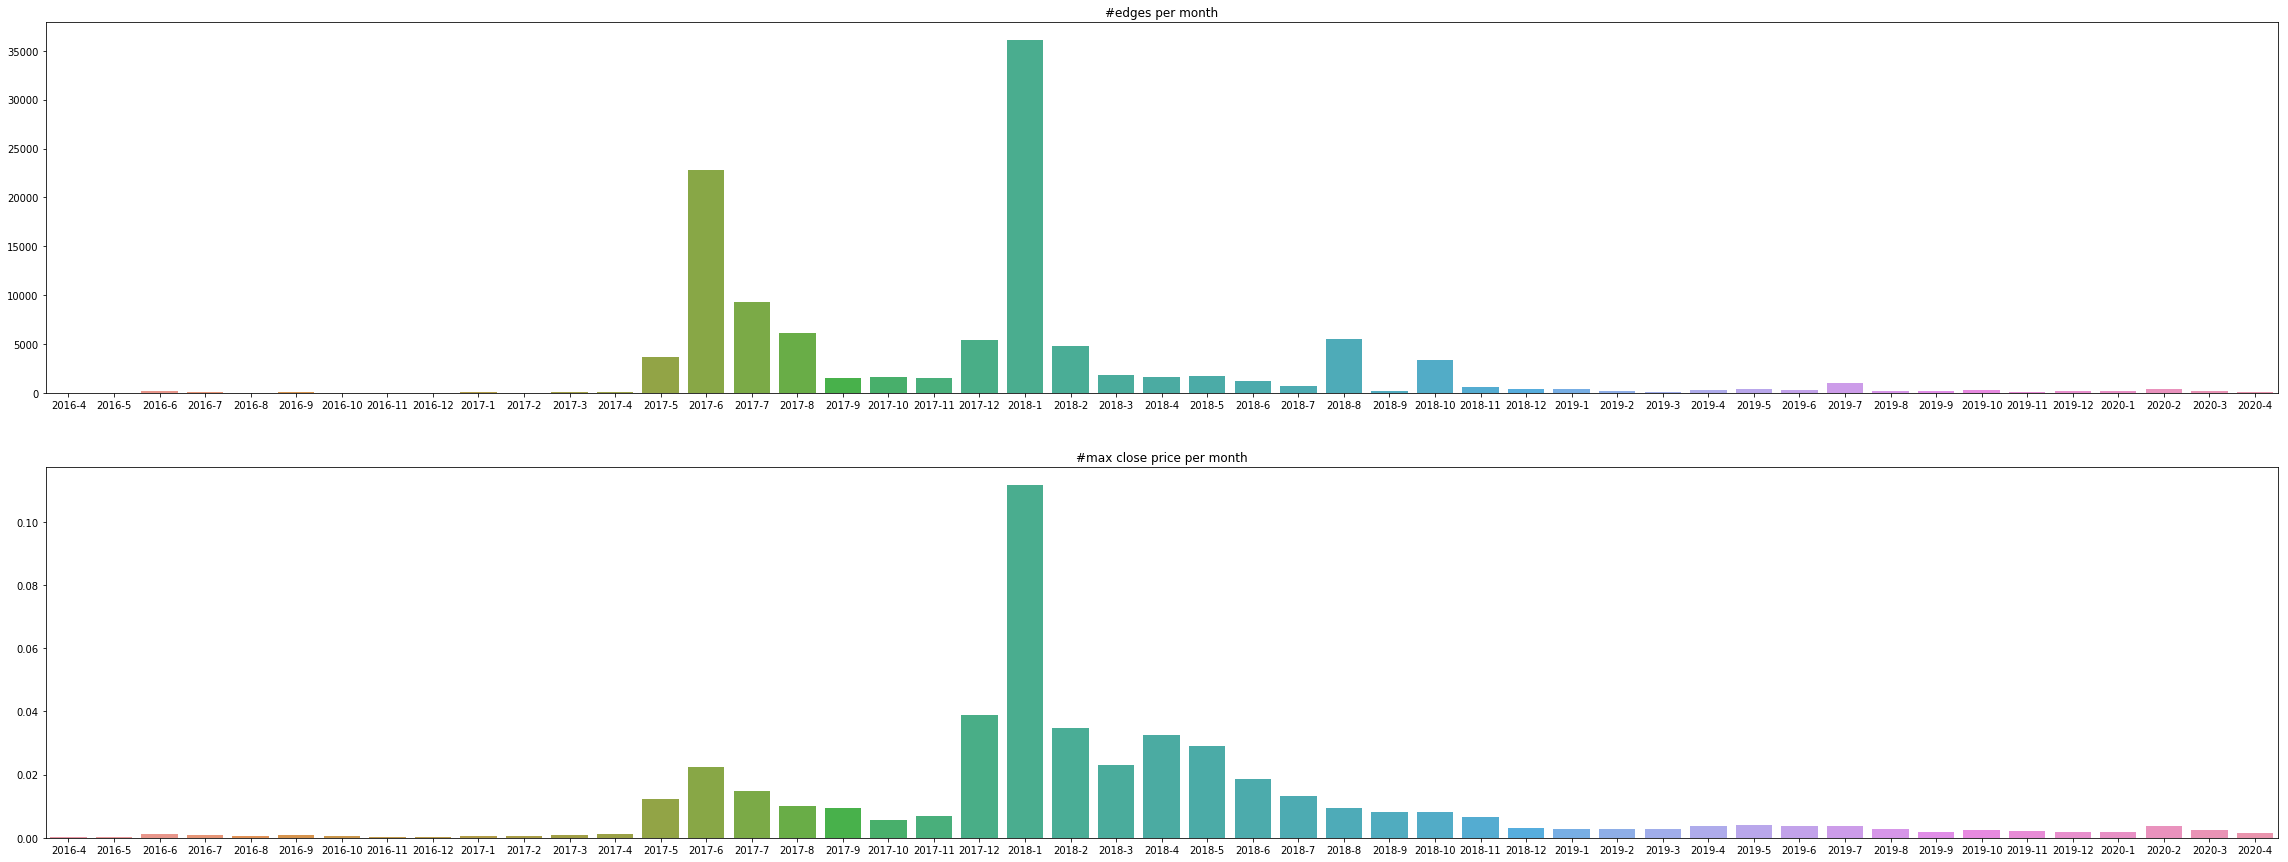

In [15]:
x = []
y = []

price_x = []
price_y = []

for key in sorted(edgelist_breakouts.keys(), key = sorter):
    x.append(key)
    y.append(len(edgelist_breakouts[key]))
    
    price_x.append(key)
    price_y.append(prices[key])

f, axes = plt.subplots(2, 1, figsize=(40, 15))

axes[0].set_title('#edges per month')
sns.barplot(x, y, ax = axes[0])

axes[1].set_title('#max close price per month')
sns.barplot(price_x, price_y, ax = axes[1])

In [16]:
import networkx as nx

In [17]:
keys = edgelist_breakouts.keys()

print(f'keys: #{len(keys)}')

keys: #49


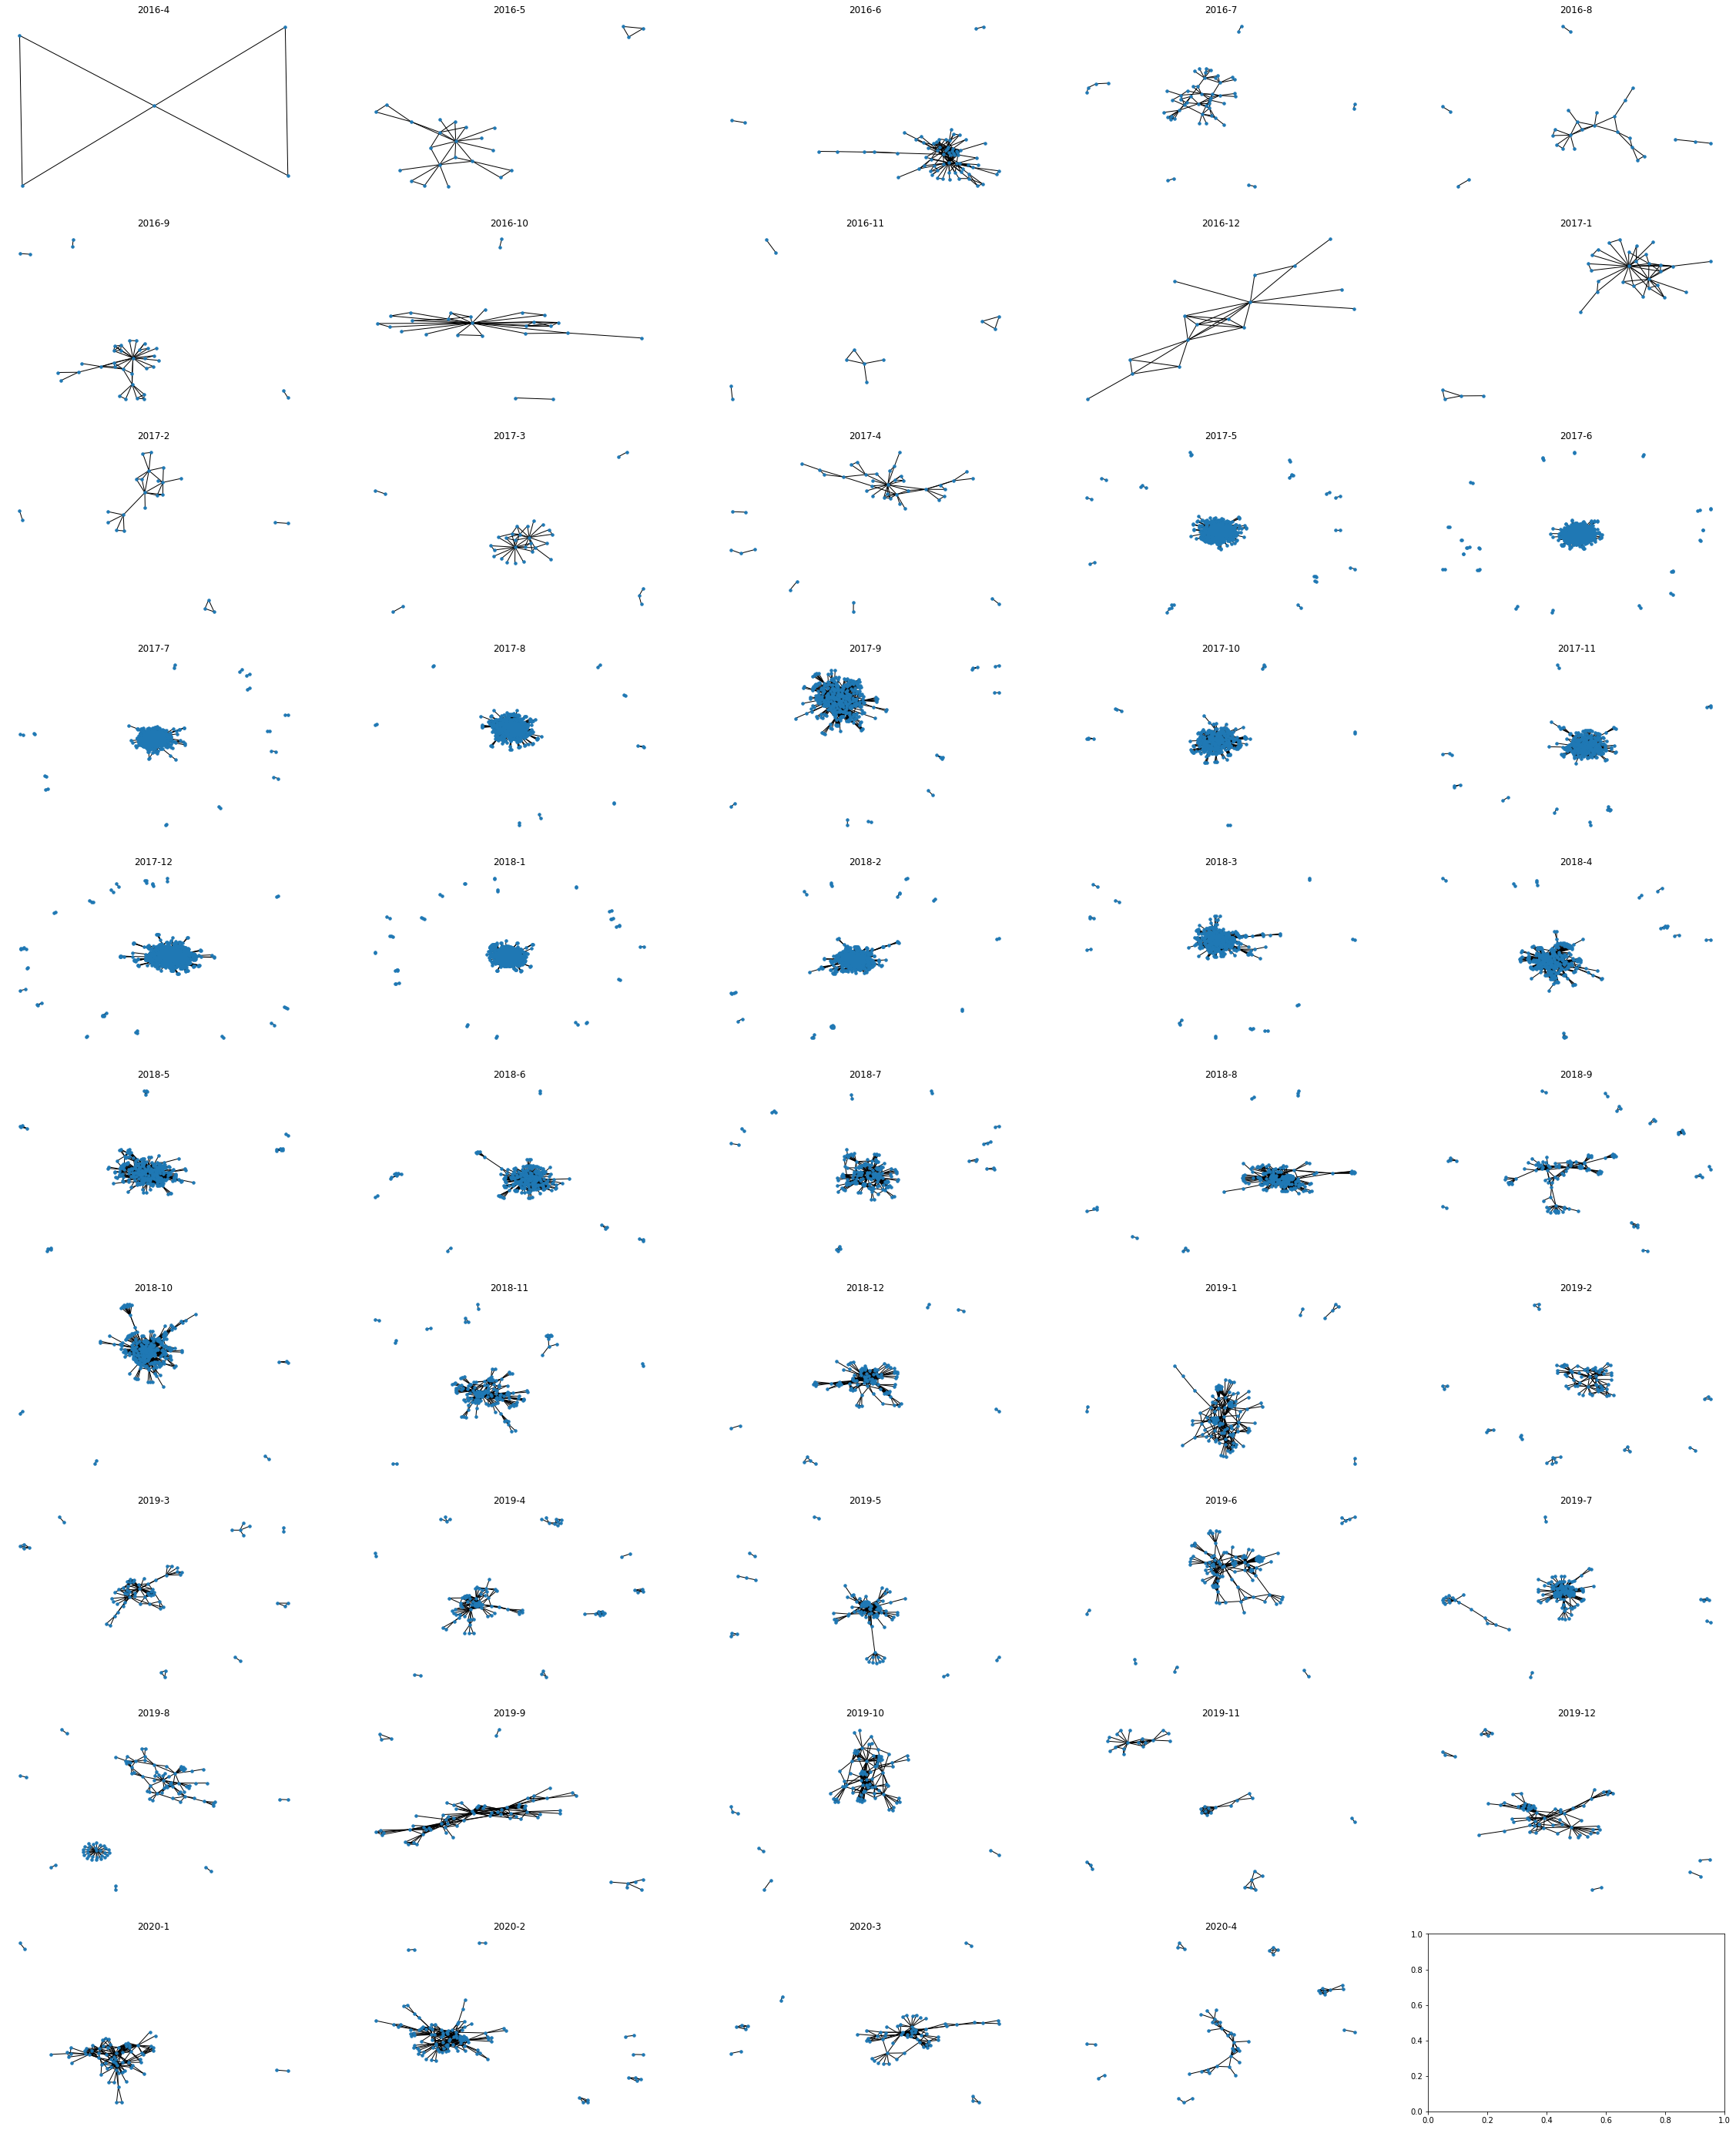

In [18]:
keys = edgelist_breakouts.keys()

plt.figure(figsize=(40, 50))
fig, axs = plt.subplots(10, 5, num = 1)

for i, key in enumerate(sorted(keys, key = sorter)):
    
    G = nx.Graph()
    
    for interaction in edgelist_breakouts[key]:
        n1 = interaction[0]
        n2 = interaction[1]

        if G.has_edge(n1, n2):
            G[n1][n2]['weight'] += 1
        else:
            G.add_edge(n1, n2, weight = 1)
    
    ix = np.unravel_index(i, axs.shape)
    positions = nx.spring_layout(G)
    nx.draw_networkx(G, pos = positions, with_labels = False, node_size = 12, ax=axs[ix])
    
    axs[ix].set_title(key)
    axs[ix].set_axis_off()

In [19]:
## computing centrality metrics for last month,

In [20]:

import pandas as pd

In [21]:
data = {
    '#': dict(G.degree),
    'Degree': nx.degree_centrality(G),
    'Closeness': nx.closeness_centrality(G),
    'Betweenness': nx.betweenness_centrality(G),
    'Pagerank': nx.pagerank(G)
}

df = pd.DataFrame(data)

In [22]:
df.sort_values('Degree', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
Taek42,10,0.20,0.265098,0.147755,0.041730
mtlynch,9,0.18,0.237193,0.123537,0.047816
DaW_,8,0.16,0.241429,0.123265,0.036598
Rusi12,7,0.14,0.140000,0.008163,0.030327
rezant1,7,0.14,0.185205,0.059048,0.044542
adhkr,5,0.10,0.108889,0.000000,0.020699
Falco98,5,0.10,0.211250,0.000000,0.021177
kizobre,5,0.10,0.108889,0.000000,0.020699
jollyrosso,5,0.10,0.108889,0.000000,0.020699
BlindTiger86,5,0.10,0.108889,0.000000,0.020699


In [23]:
df.sort_values('Closeness', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
Taek42,10,0.20,0.265098,0.147755,0.041730
DaW_,8,0.16,0.241429,0.123265,0.036598
mtlynch,9,0.18,0.237193,0.123537,0.047816
lpadua,5,0.10,0.211250,0.000000,0.021177
Falco98,5,0.10,0.211250,0.000000,0.021177
Want-A-Cookie,5,0.10,0.211250,0.000000,0.021177
TheRealJoeyTribbiani,5,0.10,0.211250,0.000000,0.021177
aerrejon,4,0.08,0.208000,0.000000,0.017710
MeijeSibbel,4,0.08,0.208000,0.000000,0.017710
sculptex,4,0.08,0.208000,0.000000,0.017710


In [24]:
df.sort_values('Betweenness', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
Taek42,10,0.20,0.265098,0.147755,0.041730
mtlynch,9,0.18,0.237193,0.123537,0.047816
DaW_,8,0.16,0.241429,0.123265,0.036598
yogibjorn,5,0.10,0.190423,0.071837,0.027511
rezant1,7,0.14,0.185205,0.059048,0.044542
lukehmcc,3,0.06,0.182703,0.020408,0.018450
sia-steve,4,0.08,0.146957,0.020408,0.024782
Rusi12,7,0.14,0.140000,0.008163,0.030327
jetarinc,2,0.04,0.040000,0.000816,0.028628
SuperSiayuan,4,0.08,0.177895,0.000272,0.027061


In [25]:
df.sort_values('Pagerank', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
mtlynch,9,0.18,0.237193,0.123537,0.047816
rezant1,7,0.14,0.185205,0.059048,0.044542
Taek42,10,0.20,0.265098,0.147755,0.041730
DaW_,8,0.16,0.241429,0.123265,0.036598
Rusi12,7,0.14,0.140000,0.008163,0.030327
jetarinc,2,0.04,0.040000,0.000816,0.028628
yogibjorn,5,0.10,0.190423,0.071837,0.027511
SuperSiayuan,4,0.08,0.177895,0.000272,0.027061
sia-steve,4,0.08,0.146957,0.020408,0.024782
TheRealJoeyTribbiani,5,0.10,0.211250,0.000000,0.021177
